# Information theory, efficient coding and gain control


In this tutorial, we will look at a simple example of application of information theory to the study of neural systems. We will consider a simple simulated cell, and we will analyze its information transmission properties in a rate coding scenario. We will see:
1. how to estimate the mutual information between the input and the output of this cell (where the input is defined as its excitatory drive, and the output is the cell's firing rate);
2. the effect of limited sampling on the information estimate, and how it can be reduced through bias correction;
3. how adapting the gain to the stimulus distribution according to efficient coding theory results in optimal information transmission.

## Requirements, technical preliminaries and imports
To run this notebook, we will need the modules imported below. Some of them are just standard data manipulation/analysis modules (`numpy`, `xarray`), visualization (`matplotlib`, `seaborn`), or convenience utilities (`tqdm`). Two of them, however, are specific to our tutorial. One is `neuron`, and hopefully needs no introduction. The other is [`ndd`](https://github.com/simomarsili/ndd), which implements a sophisticated technique for estimating information-theoretical quantities. These modules are all available via `pip`.

In [20]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import ndd

This notebook comes with a mod-file which we will use in our simulations. This mod file implements the spiking mechanism for a conductance-based ("coba") integrate and fire neuron. This particular file is adapted from Brette et al 2007 ([ModelDB#83319](http://modeldb.yale.edu/83319)).

Before we get started with NEURON, we make sure that the mod file is properly compiled and ready to be used.

In [2]:
!nrnivmodl spikeout

/home/eugenio/virtualenvs/base/bin/nrnivmodl:11: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.ccompiler import new_compiler
/home/eugenio/Dropbox/sissa/teaching/neuronschool
Mod files: "./spikeout.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
from neuron import h
from neuron.units import ms, mV, µm, cm, s

h.load_file("stdrun.hoc")
h.cvode_active(1);

## Define conductance-based integrate-and-fire cell and basic simulation to support FF curve analysis
We now define a simple neuron model that we will use for our simulations below. This is an adaptation of the model used in [Mitchell and Silver, Neuron 2003, *Shunting inhibition modulates neuronal gain during synaptic excitation*](https://doi.org/10.1016/S0896-6273(03)00200-9) for the cerebellar granule cell. For the purposes of this tutorial we will simply look at this neuron as a rate-coding information channel: it receives some input in the form of an excitatory spike train, and encodes it in its output firing range. The neuron can also receive inhibitory input, which will modulate its transfer function. The excitatory and inhibitory inputs are loosely modeled after, respectively, the mossy fiber to granule cell AMPA synapse and the Golgi cell to granule cell GABA synapse.

In [13]:
class COBA:
    """
    This conductance-based integrate and fire neuron is a simplified version of the one used in Mitchell and Silver, Neuron 2003.
    """
    def __init__(self):
        self._setup_morphology()
        self._setup_biophysics()
        
        self._spike_detector = h.NetCon(self.spikeout, None)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)


    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.soma.L = self.soma.diam = 5.6418958 * µm # this way the surface area is about 100µm^2
        self.area = self.soma.L * self.soma.diam * np.pi

    def _setup_biophysics(self):
        self.capacitance = 3.1 # pF
        self.soma.cm = self.capacitance * 1e-6 / (self.area/cm**2) # Membrane capacitance in µF / cm^2
        
        # Create spiking mechanism
        self.spikeout = h.SpikeOut(self.soma(0.5))
        self.spikeout.thresh = -49 * mV # Spike threshold
        self.spikeout.refrac = 2.5 * ms # Refractory period
        self.spikeout.vreset = -75 * mV # Reversal potential to clamp to during the spike
        self.spikeout.grefrac = 100 / (self.area/cm**2) # Conductance used to clamp during refractory period (S/cm2)

        # Inser leak
        self.soma.insert("pas")
        for seg in self.soma:
            seg.pas.g = 385*1e-12 / (self.area/cm**2)  # Passive conductance in S/cm2
            seg.pas.e = -75 * mV  # Leak reversal potential
        
        # Define timecourse and reversal potential of excitatory input
        self.exc = h.ExpSyn(self.soma(0.5))
        self.exc.tau = 10 * ms
        self.exc.e = 0 * mV

        # Define timecourse and reversal potential of inhibitory input
        self.inh = h.ExpSyn(self.soma(0.5))
        self.inh.tau = 12 * ms
        self.inh.e = -75 * mV
        
    def __repr__(self):
        return f"Conductance-based IaF cell"

We now simulate a current clamp experiment to show how the model works.

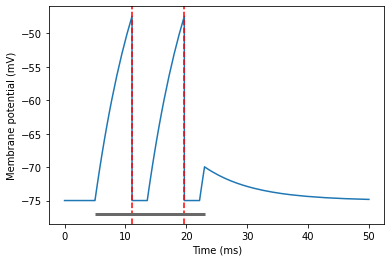

In [62]:
cell = COBA()
stim = h.IClamp(cell.soma(1))
stim.delay = 5
stim.dur = 18
stim.amp = 0.02 # (nA)
soma_v = h.Vector().record(cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.v_init = -75
h.tstop = 50
h.finitialize()
h.run()

plt.plot(t, soma_v)
for spike in cell.spike_times:
    plt.axvline(spike, color='red', linestyle='--')
plt.hlines(-77, stim.delay, stim.delay+stim.dur, linewidth=3, color='dimgray')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)');

Here we inject current for 18ms, starting at 5ms into the simulation (dark gray bar). We can see how the injected current increases the membrane potential until it reaches the designated threshold value (-45mV in our case). When this happens, the membrane potential is reset at a specified value (here -75mV) and clamped there for the duration of the refractory interval (here 2.5ms). In absence of stimulation, the membrane potential decays exponentially towards the reversal potential of the leak confuctance (also -75mV in this case). Note that we don't simulate the shape of the spike, but we record spike events for further processing in the `cell.spike_times` array (actually a NEURON `Vector`). Here we highlight the recorded spike times by plotting them as dashed red lines.

## Compute FF curve
With the above machinery in place, we are ready to start looking at the behavior of our model cell in the rate-coding regime. We start by defining a utility function that will run a simple "rate simulation". Here we simulate the cell for a certain amount of time, with excitatory and inhibitory inputs given by Poisson spike trains at given mean rates. We record the spikes of the cell, discarding any spike happening within an initial transient). The output of the function is the firing rate corresponding to the recorded number of spikes.

In [63]:
def rate_simulation(cell=None, exc_rate=10, inh_rate=0, duration=0.4, transient=0.2):
    """
    Simple rate-coding simulation.
    
    Arguments
    
    cell : model to be simulated
    
    exc_rate : mean rate of the excitatory synaptic input, in Hz (Poisson)
    
    inh_rate : mean rate of the inhibitory synaptic input, in Hz (Poisson)
    
    duration : duration of the simulation, in seconds
    
    transient : duration of the initial transient (in seconds). The transient does not count towards the estimation of the output firing rate.
    
    
    Returns:
    
    float : estimated output firing rate, in Hz.
    
    """
    
    cell = cell if cell is not None else COBA()
    
    if exc_rate > 0:
        stim_exc = h.NetStim()
        stim_exc.interval = 1/exc_rate * (s/ms)
        stim_exc.start = 0
        stim_exc.number = exc_rate * duration
        stim_exc.noise = 1
        ncstim_exc = h.NetCon(stim_exc, cell.exc)
        ncstim_exc.delay = 0
        ncstim_exc.weight[0] = 732 * 1e-6

    if inh_rate > 0:
        stim_inh = h.NetStim()
        stim_inh.interval = 1/inh_rate * (s/ms)
        stim_inh.start = 0
        stim_inh.number = inh_rate * duration
        stim_inh.noise = 1
        ncstim_inh = h.NetCon(stim_inh, cell.inh)
        ncstim_inh.delay = 0
        ncstim_inh.weight[0] = 3100 * 1e-6
    
    h.tstop = duration * (s/ms)
    h.v_init = -75
    h.finitialize()
    h.run()
    
    if len(cell.spike_times)==0:
        nspikes = 0
    else:
        spikes = np.array(cell.spike_times)
        nspikes =  (spikes>transient*(s/ms)).sum()
    out_rate = nspikes / (duration-transient)
    
    return out_rate

We can now run this function several times, as we vary the excitatory and inhibitory input rates, to get an idea of the rate-coding transfer function of our cell. We plot this transfer function as an FF (from "output frequency, stimulation frequency") curve. Throughout this notebook, we always keep the duration of the simulation at 400ms and the duration of the initial transient period at 200ms, resulting in a 200ms time window for the estimation of the firing rate.

In [6]:
n_trials = 50
exc_rate_range = np.linspace(0, 1000, 11)
inh_rate_range = np.linspace(0, 100, 6)

firing_rate = xr.DataArray(
    name='Firing rate (Hz)',
    dims=['Exc rate (Hz)', 'Inh rate (Hz)', 'Trial'],
    coords=[exc_rate_range, inh_rate_range, range(n_trials)])

for trial in tqdm(firing_rate.coords['Trial']):
    for i, exc in enumerate(firing_rate.coords['Exc rate (Hz)']):
        for j, inh in enumerate(firing_rate.coords['Inh rate (Hz)']):
            firing_rate[i,j,trial] = rate_simulation(exc_rate=exc, inh_rate=inh)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]


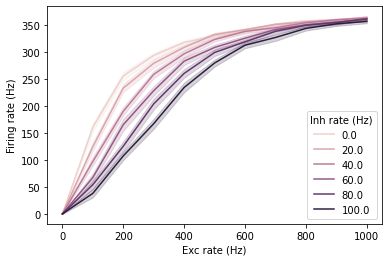

In [7]:
sns.lineplot(data=firing_rate.to_dataframe(), x='Exc rate (Hz)', y='Firing rate (Hz)', hue='Inh rate (Hz)');

From the plot above, we can see how the transfer function of the neuron is modulated by the inhibitory drive. The shape of the curves is similar, but higher values of the inhibition correspond to shallower curves; conversely, lower levels of the inhibition correspond to steeper curves (cf. Figure 8B in Mitchell and Silver 2003, of which this result is a qualitative reproduction). This type of modulation, which alters the steepness of the transfer function, is often called **gain control** ("gain" being the steepness here).

Now imagine the following situation. Say that the cell needs to encode information that happens to be encoded in the rate of the excitatory drive. Assume that the possible range of input firing rates goes from 0 (no spikes) to some maximum value $x_\text{max}$. For instance, say that on any given trial the actual input rate $x$ will be sampled at random from the uniform distribution between 0 and $x_\text{max}$, or
$$x\sim U(0,x_\text{max})$$
This will result in a corresponding output firing rate, $y$. Over a large number of trials, this will also result in a distribution of neuronal responses over values of $y$. If we (as "neural circuit designers") are free to choose the level of inhibition, what level should we choose in order to ensure optimal transmission of the signal by our neuron?

The answer is that it depends. When the range of possible inputs is broad, say 0-800Hz, it seems better to impose a low gain on the transfer function, because high gain leads to saturation over that range of inputs. However, if we make the input range gets narrower, it is advantageous to increase the gain: for instance, if the input range is 0-200Hz the neuron can easily encode any input without saturating, and having a higher gain will lead to better utilization of the neuron's output range. In other words, if the input range is 0-200Hz then the neuron never saturates, but if the gain is low (high inhibition) then all output are compressed in a small range of possible firing rates, increasing the probability of encoding error.

We will now try to make these intuitions more precise by measuring the quality of the neuron's encoding with the mutual information between its input and its output.

## Estimate information transmission in the rate-coding regime
### Theory recap
As discussed above, we can conceptualize a simple rate-coding scenario by imagining that on each trial there is an input frequency $x\sim U(0,x_\text{max})$ which elicits an output firing rate $y$. Therefore, to assess the degree to which $y$ carries information about $x$ we can consider $x$ and $y$ as two random variables, and compute their **mutual information**:
$$
I[X:Y] = \sum_{x,y}p(x,y)\log\frac{p(x,y)}{p(x)p(y)}
$$

As we know, $I[X:Y]$ can be written in several equivalent ways. Below we will use the following form:
$$
I[X:Y] = H[Y] - H[Y|X]
$$
where $H[Y]$ is the **entropy** of the random variable $Y$,
$$
H[Y] = -\sum_y p(y) \log p(y)
$$
and $H[Y|X]$ is the **conditional entropy** of $Y$ given $X$
$$
H[Y|X] = \sum_x p(x) H[Y|X=x] = -\sum_{x,y} p(x)p(y|x)\log p(y|x)
$$

In words, we can then read the definition of the mutual information as **"the variability in the neuron's output ($H[Y]$) minus the variability that persists when the input is fixed, and is therefore due to noise ($H[Y|X]$)."**

### Implementing the information-theoretical analysis
We now define a set of functions that allow us to simulate the scenario described above, and to estimate the mutual information between the input and the output of the neuron. Importantly, because $x$ and $y$ here can take on continuous values, we will have to simplify the problem by **binning** them.

In [64]:
def input_output_simulation(exc_max, inh, n_trials=100, **kwargs):
    in_freqs = np.random.uniform(low=0, high=exc_max, size=n_trials)
    out_freqs = np.array([rate_simulation(exc_rate=exc, inh_rate=inh, **kwargs) for exc in in_freqs])
    return in_freqs, out_freqs

def digitize(array, n_bins, mode='uniform'):
    if mode=='uniform':
        digitized = np.digitize(array, bins=np.linspace(array.min(), array.max(), n_bins+1))
    elif mode=='quantiles':
        digitized = np.digitize(array, bins=np.percentile(array, np.linspace(0, 100, n_bins+1)))
    return digitized

def entropy(p):
    # make sure that p is an array
    p = np.asarray(p)
    # since p(x)log[p(x)]→0 as p(x)→0, we exclude any x such that p(x)=0 from the calculation
    p = p[p>0]
    # compute Σp(x)log[p(x)]
    h = (-p * np.log2(p)).sum()
    return h

def mutual_information_naive(xy):
    xy = np.asarray(xy)
    x = xy[:,0]
    y = xy[:,1]
    
    alphabet_x, counts_x = np.unique(x, return_counts=True)
    alphabet_y, counts_y = np.unique(y, return_counts=True)
    
    # marginal probability dist of Y: p(Y=y)
    py = counts_y/counts_y.sum()
    # marginal entropy H[Y]
    HY = entropy(py)
    
    # conditional probability distribution of Y given X: p(Y=y|X=x) and its entropy H[Y|X=x]
    HY_x = np.zeros(alphabet_x.size)
    
    for i, this_x in enumerate(alphabet_x):
        _, counts = np.unique(y[x==this_x], return_counts=True)
        py_x = counts/counts.sum()
        HY_x[i] = entropy(py_x)
    
    # average H[Y|X=x] over p(x) to obtain the conditional entropy H[Y|X]=ΣH[Y|X=x]p(x)
    HY_X = np.inner(HY_x,  counts_x/counts_x.sum())
    
    # mutual information is marginal entropy minus conditional entropy: MI[X:Y]=H[Y]-H[Y|X]
    IXY = HY - HY_X
    
    return IXY


def estimate_information(exc_max, inh, n_bins=10, bias_correction=True, **kwargs):
    # simulate stimulus-response for a number of trials
    in_freqs, out_freqs = input_output_simulation(exc_max, inh, **kwargs)
    # bin stimulus and response firing rates
    in_binned = digitize(in_freqs, n_bins=n_bins)
    out_binned = digitize(out_freqs, n_bins=n_bins)
    # compute mutual information
    io_table = np.vstack((in_binned, out_binned)).T
    if bias_correction:
        # using NSB method (note unit conversion, as the ndd module returns a result in nats, not bits)
        information = ndd.mutual_information(io_table) * np.log2(np.e)
    else:
        information = mutual_information_naive(io_table)
    return information

In [69]:
exc = 200
inh = 10
n_bins = 10
n_trials = 100
duration = 0.4
transient = 0.2

print(f"Information transmitted over a {(duration-transient)*1000} ms time window, \
with input and output firing rates binned in {n_bins} possible values, \
evaluated over {n_trials} trials, \
for excitatory input uniformly distributed between 0 and {exc} Hz, and {inh} Hz inhibitory input: \
{estimate_information(exc, inh, n_bins, n_trials=n_trials, duration=duration, transient=transient):.2g} bit")

Information transmitted over a 200.0 ms time window, with input and output firing rates binned in 10 possible values, evaluated over 100 trials, for excitatory input uniformly distributed between 0 and 200 Hz, and 10 Hz inhibitory input: 1.2 bit


## Demonstrate undersampling bias

In [67]:
n_bins_range = np.array([2, 4, 6])
n_trials_range = np.concatenate((np.arange(2, 21, 1, dtype='int'), np.array([50, 80, 100])))
n_repetitions = 10

mi_for_bias_comparison = xr.DataArray(
    dims=['Estimator', 'N. of bins', 'N. of trials', 'N. of repetitions'],
    coords=[['Bias-corrected (NSB)', 'Naive'], n_bins_range**2, n_trials_range, range(n_repetitions)],
    name='Mutual Information (bit)')

for rep in tqdm(range(n_repetitions)):
    for i, n_bins in enumerate(n_bins_range):
        for j, n_trials in enumerate(n_trials_range):
            in_freqs, out_freqs = input_output_simulation(exc_max=200, inh=10, n_trials=n_trials)
            in_binned = digitize(in_freqs, n_bins=n_bins)
            out_binned = digitize(out_freqs, n_bins=n_bins)
            io_table = np.vstack((in_binned, out_binned)).T
            mi_for_bias_comparison[0,i,j,rep] = ndd.mutual_information(io_table) * np.log2(np.e)
            mi_for_bias_comparison[1,i,j,rep] = mutual_information_naive(io_table)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.05s/it]


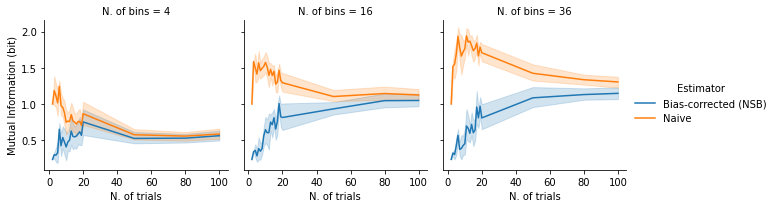

In [68]:
g = sns.FacetGrid(data=mi_for_bias_comparison.to_dataframe().reset_index(), col='N. of bins', col_wrap=3, hue='Estimator')
g.map(sns.lineplot, 'N. of trials', 'Mutual Information (bit)')
g.add_legend();

We can see that, for sufficiently large number of trials, the MI estimates converge, regardless of the estimator (with or without bias correction). However, when data is scarce (low N. of trials) the naive approach systematically overestimates the information. The bias-corrected estimator also behaves poorly at extremely low N. of trials, but in general it converges to sensible values faster than the naive approach. Note also that the undersampling bias gets worse as the dimensionality of the input/output relationship considered (number of bins, in this case) increases.

## Demonstrate optimal gain control

In [11]:
n_trials = 1000
n_bins = 4
exc_max_range = np.linspace(0, 1000, 6)
inh_range = np.linspace(0, 100, 6)

mi = xr.DataArray(
    dims=['Exc input range (Hz)', 'Inh rate (Hz)'],
    coords=[exc_max_range, inh_range],
    name='Mutual Information (bit)')

for i, exc_max in enumerate(tqdm(mi.coords['Exc input range (Hz)'])):
    for j, inh in enumerate(mi.coords['Inh input range (Hz)']):
        mi[i,j] = estimate_information(exc_max, inh, n_bins=n_bins, n_trials=n_trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:16<00:00, 52.73s/it]


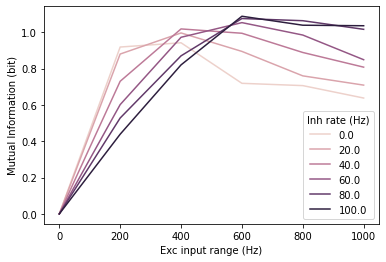

In [12]:
sns.lineplot(data=mi.to_dataframe(), x='Exc input range (Hz)', y='Mutual Information (bit)', hue='Inh rate (Hz)');

By looking at the curves above, we can see that as the dynamic range of the stimulus increases (on the x axis) the optimal configuration that transmits the most information has more and more inhibition. This is because, as shown by the FF curve we computed at the beginning of the notebook, higher inhibition results in lower "gain" for the rate-transfer function of the neuron, allowing the neuron to transmit information over a broader range of inputs. In other words, when the gain is high (low inhibition) the neuron is very sensitive over a narrow range of stimuli, but saturates for relatively low input frequencies; on the other hand, when gain is low (high inhibition) the neuron is never as sensitive as a high-gain neuron, but maintains its sensitivity over a broader input range.